In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 300

# import warnings
# warnings.simplefilter('ignore')

In [2]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (8,5)

## Helper Functions

In [4]:
def residual_plot(y_pred, y_train, title=None):
    res = y_train - y_pred
    plt.scatter(y_pred, res, s=3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    if title:
        plt.title(title)
    return plt
#     plt.show()
#     return result

### Preprocessing

In [5]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df, minvotes=4)

In [6]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype



cont_feats = ['countreports', 'length', 'gain', 'hpoint']
# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint', 'log_countreports', 'log_votes']
# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']
# cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']

oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])

# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
y = df['rating'] # SEE BELOW - I turn y and X from an np array into a pandas DF

# This code makes a DF of my transformed variables. There is some weird stuff in there with neg lengths...
y2 = y[:,np.newaxis]
XSpecial = np.concatenate([X, y2], axis=1)
df_model = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['rating']))

y = df_model['rating']
X = df_model.drop('rating',axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Test Train Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [8]:
alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]

# Linear Regression

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("intercept:",lr.intercept_)
# print("coefficients,",lr.coef_)

y_pred_tr = lr.predict(X_train)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_tr)))
print("Train MSE:", metrics.mean_squared_error(y_train, y_pred_tr))
print("Train R^2:", lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))z

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lr.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.5484089535988073
Train RMSE: 0.5851137357350953
Train MSE: 0.34235808374587895
Train R^2: 0.25036602330593194




In [10]:
"""Polynomial with LinearRegression"""

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)

y_pred_tr = poly_lr.predict(X_train)


print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")


y_pred_test = poly_lr.predict(X_test)

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print('Test R^2: ', poly_lr.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lr.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.38788941052659315
Train MSE: 0.15045819479866793
Train R^2: 0.6705537849170362

Test RMSE: 863021475.7094227
Test MSE: 7.448060675356698e+17
Test R^2:  -1.7596325437406505e+18



<module 'matplotlib.pyplot' from '/home/spencer/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

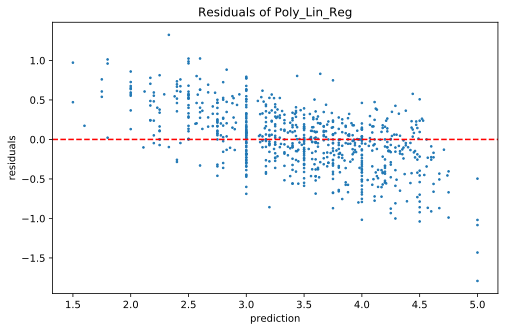

In [11]:
# plot of poly_lr
residual_plot(y_train, poly_lr.predict(X_train), "Residuals of Poly_Lin_Reg")

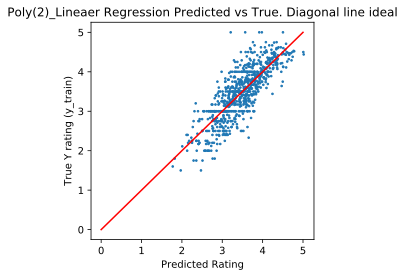

In [12]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lr.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.title("Poly(2)_Lineaer Regression Predicted vs True. Diagonal line ideal")
plt.plot(range(6), c='r');

# Lasso

In [13]:
#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("intercept:",lasso.intercept_)
# print("coefficients,",lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("Train R^2:", lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lasso.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.244355053840742
Train RMSE: 0.590950838215091
Train MSE: 0.3492228931871186
Train R^2: 0.23533470187669073




In [14]:
"""Polynomial with LassoCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_lasso = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(cv=3, alphas=alphas))
poly_lasso.fit(X_train, y_train)
#print("intercept:",poly_lasso.intercept_)
# print("coefficients,",poly_lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))

print("")

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Train RMSE: 0.5793540356629211
Train MSE: 0.3356510986389133
Train R^2: 0.26505176947658327

Test RMSE: 0.5873550655213777
Test MSE: 0.34498597299362194
Test R^2:  0.1849575726173336



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [15]:
# simple_lasso= LassoCV(cv=3)
# simple_lasso.fit(X_train, y_train)

In [16]:
# coefs_list = X.columns
# # newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# # newlist = cont_feats ## only continuous features
# import pprint
# coefs = sorted(zip(coefs_list, np.round(simple_lasso.coef_,3)), key=lambda x: x[1], reverse=True)
# pprint.pprint(coefs)

In [17]:
# coefs

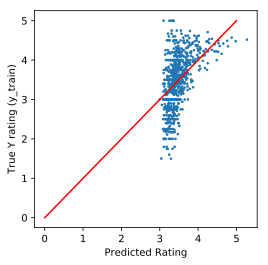

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lasso.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

# Ridge Regression

In [19]:
#Straight Ridge Regression

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("intercept:",ridge.intercept_)
# print("coefficients,",ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("Train R^2:", ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(ridge.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.255170055498748
Train RMSE: 0.5865225212305624
Train MSE: 0.34400866791065554
Train R^2: 0.24675187183688663




In [20]:
"""Polynomial with RidgeCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_ridge = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(cv=3, alphas=alphas))
poly_ridge.fit(X_train, y_train)
#print("intercept:",poly_ridge.intercept_)
# print("coefficients,",poly_ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_ridge.coef_,3)), key=lambda x: x[1], reverse=True))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.708044e-17
  overwrite_a=False)
/home/spe

Train RMSE: 0.5450681189211329
Train MSE: 0.2970992542642223
Train R^2: 0.34946564424561544

Test RMSE: 0.5969263762307844
Test MSE: 0.356321098640016
Test R^2:  0.15817790896505143

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
# residual_plot(y_train, poly_ridge.predict(X_train))

# Elastic Net (L1 = 0.1)

In [22]:
poly_elastic = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio=0.1, cv=5, alphas=alphas))
poly_elastic.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_elastic.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_elastic.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_elastic.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_elastic.predict(X_test)))
print('Test R^2: ', poly_elastic.score(X_test, y_test))

print("")
print("alpha used:", poly_elastic.get_params()['elasticnetcv'].alpha_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

RR - Poly 2
Train R^2: 0.2595868818523146
Train MSE: 0.33814691461457413

Test RMSE: 0.5810292325162482
Test MSE: 0.33759496903842034
Test R^2:  0.20241909939237668

alpha used: 0.1


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# Test Suite
* This runs multiple models on the data and prints out its output. Included is an ElasticNet model (which ended up performing best)

In [23]:
alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]

# lr = LinearRegression()
# lr.fit(X_train, y_train)
# print("LinReg - Poly 1")
# print("Train R^2:", lr.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
# print("")

# poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
# # cross_validate(poly_lr, X_train, y=y_train)
# poly_lr.fit(X_train, y_train)
# print("LinReg - Poly 2")
# print("Train R^2:", poly_lr.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
# print("")

# lasso = LassoCV(cv=5, alphas=alphas)
# lasso.fit(X_train, y_train)
# print("LassoCV - Poly 1")
# print("Train R^2:", lasso.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
# print("")

poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV(cv=5, alphas=alphas))
poly_lasso.fit(X_train, y_train)
print("LassoCV - Poly 2")
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))

print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))
print("alpha used:", poly_lasso.get_params()['lassocv'].alpha_)


# ridge = RidgeCV(cv=5)
# ridge.fit(X_train, y_train)
# print("RR - Poly 1")
# print("Train R^2:", ridge.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
# print("")

poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5, alphas=alphas))
poly_ridge.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)


poly_elastic = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio=0.1, cv=5, alphas=alphas))
poly_elastic.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_elastic.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_elastic.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_elastic.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_elastic.predict(X_test)))
print('Test R^2: ', poly_elastic.score(X_test, y_test))

print("")
print("alpha used:", poly_elastic.get_params()['elasticnetcv'].alpha_)


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

LassoCV - Poly 2
Train R^2: 0.2852163418570681
Train MSE: 0.3264419317996743

Test RMSE: 0.5817381104253544
Test MSE: 0.3384192291212618
Test R^2:  0.20047175372819181
alpha used: 0.01


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anacon

RR - Poly 2
Train R^2: 0.3678721404469316
Train MSE: 0.2886930013943232

Test RMSE: 0.5812185494805799
Test MSE: 0.33781500226030936
Test R^2:  0.20189926257200663

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

RR - Poly 2
Train R^2: 0.2595868818523146
Train MSE: 0.33814691461457413

Test RMSE: 0.5810292325162482
Test MSE: 0.33759496903842034
Test R^2:  0.20241909939237668

alpha used: 0.1


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best performing model is the ElasticNet tuned 0.1 to L1 and 0.9 to L2.

# Plots

## Major issues with my model. Below plot shows it doesn't predict scores less than 3.

This indicates to me I should transform some variables. I was lead to believe transformations to possibly the target (rating) and/or continuous features (length, elevation gain, etc) could help it. Unfortunately, I ran out of time and did not do so for the sake of this project.

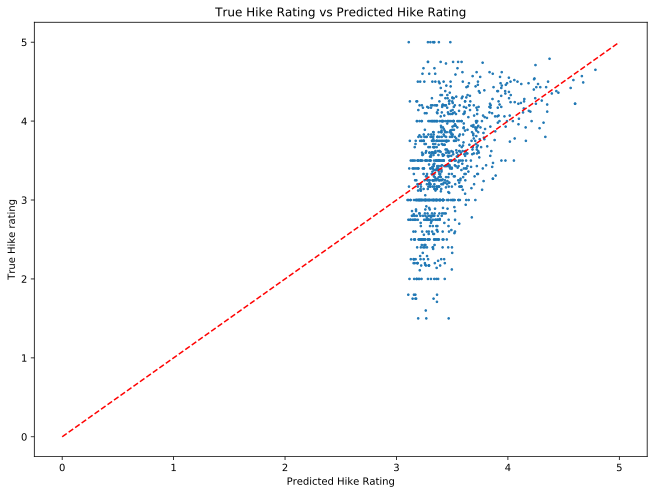

In [24]:
plt.figure(figsize=(11,8))
plt.scatter(poly_elastic.predict(X), y, s=3)
plt.xlabel("Predicted Hike Rating")
plt.ylabel("True Hike rating")
plt.title("True Hike Rating vs Predicted Hike Rating")
plt.plot(range(6), c='r', ls="--");

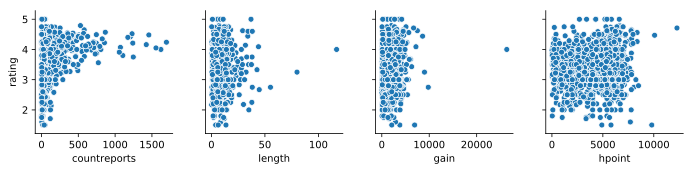

In [25]:
sns.pairplot(df, y_vars = 'rating', x_vars= cont_feats);

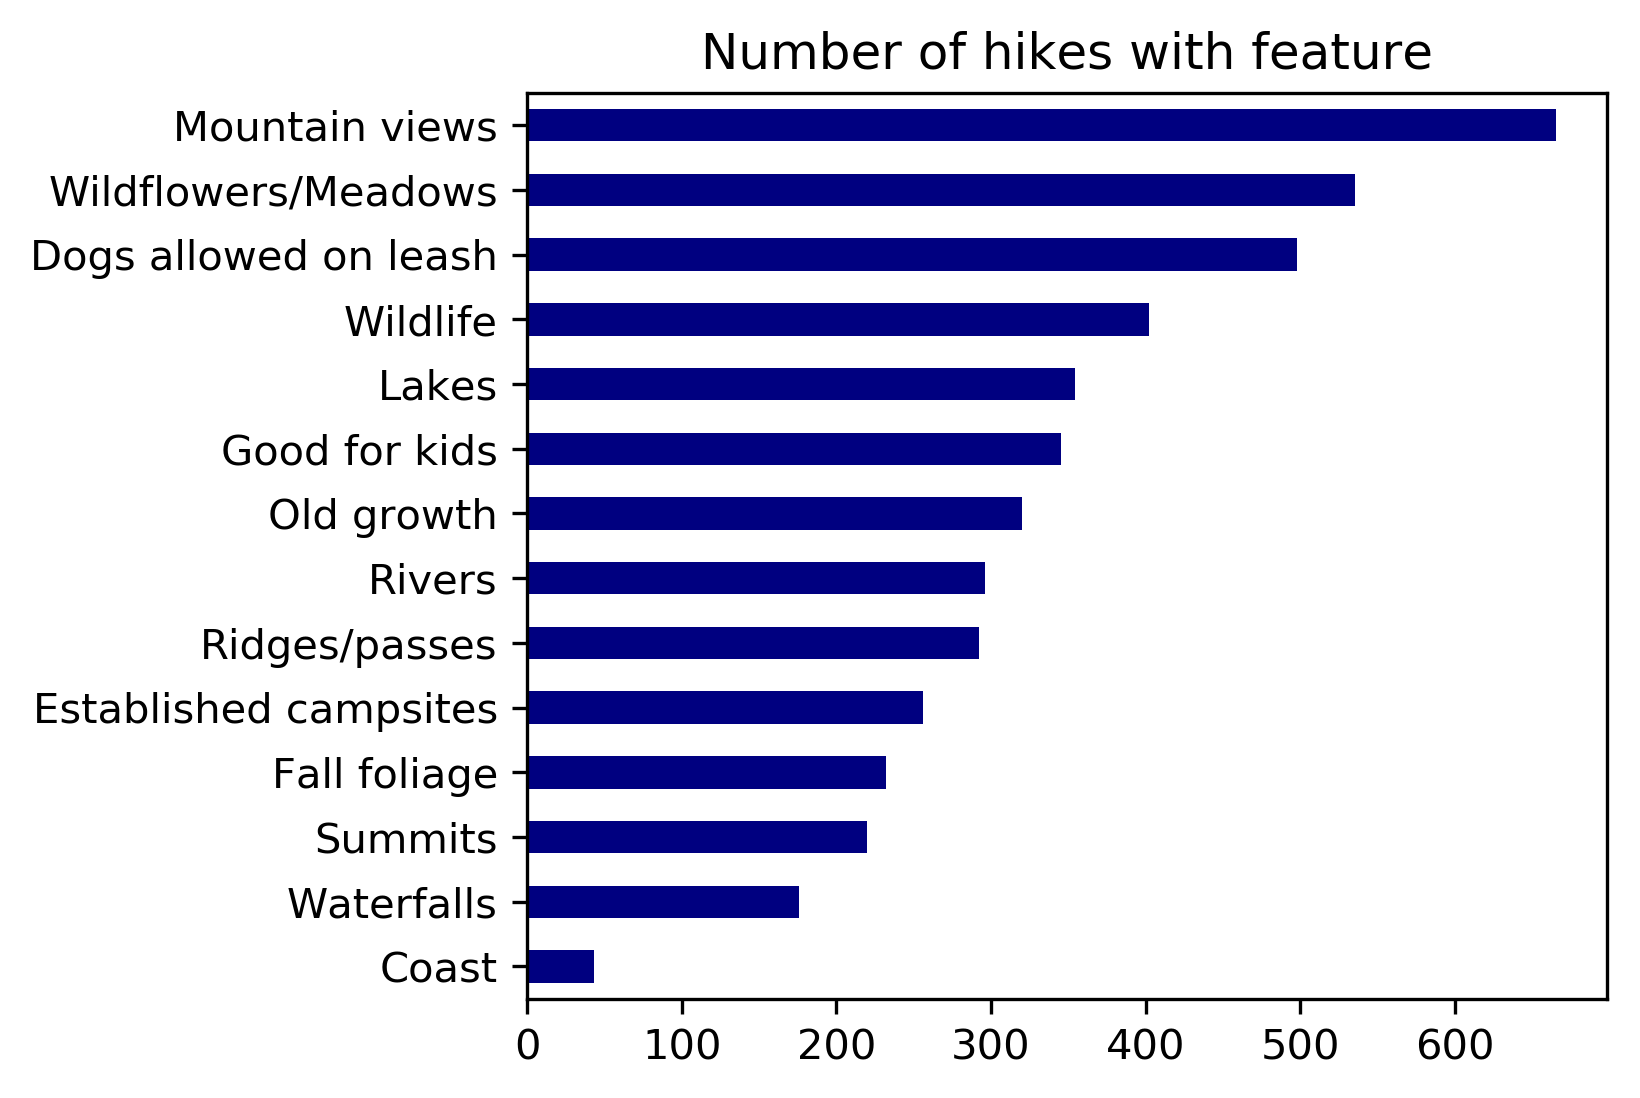

In [16]:
hike_bar = df[onehot_feats].sum().sort_values().plot.barh(title="Number of hikes with feature", color='navy').get_figure()
# hike_bar.subplots_adjust(left=.3)
# hike_bar.savefig('hike_bar_blog.png')

### Again, residuals plot shows clear errors in model. There's a clear downward trend indicating ratings far away from the mean/median (3.3ish) are not being predicted well

This was another place in model I did not get to correcting (and ran out of time)

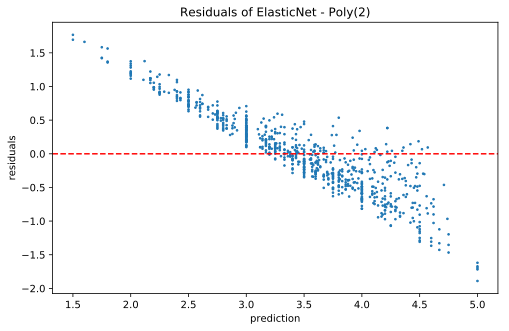

In [27]:
# plot of poly_lr
residual_plot(y_train, poly_elastic.predict(X_train), "Residuals of ElasticNet - Poly(2)");

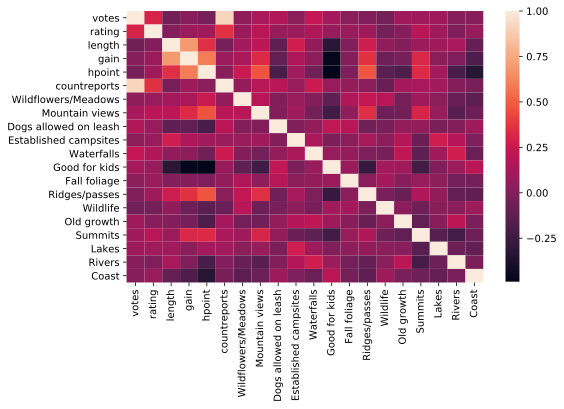

In [28]:
sns.heatmap(df.corr());

In [29]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

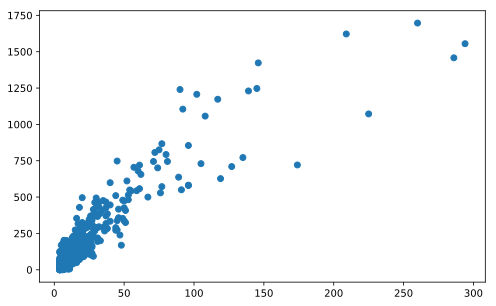

In [30]:
# votes and count reports are highly correlated
plt.scatter(df['votes'], df['countreports']);

# Doing sanity test / Experimental Work with Tranformations and Random Forest Regression


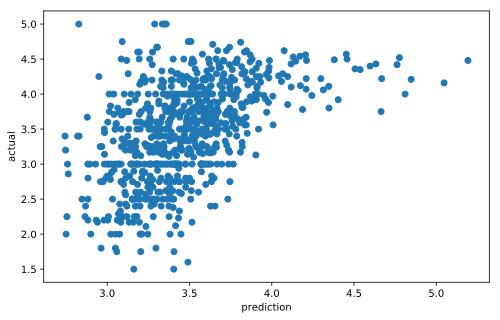

In [31]:
from sklearn.linear_model import Ridge, Lasso

lm = Ridge()

lm.fit(X_train, y_train)
plt.scatter(lm.predict(X_train), y_train)
plt.xlabel('prediction')
plt.ylabel('actual');

In [32]:
lm.intercept_

3.359397116102388

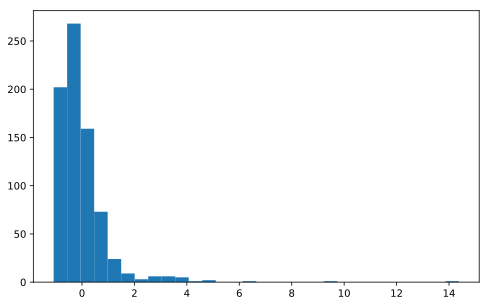

In [33]:
plt.hist(X_train['length'], bins=30);

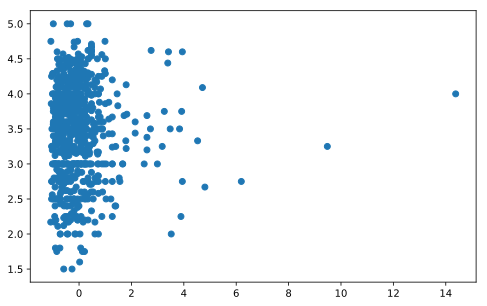

In [34]:
plt.scatter(X_train['length'], y_train);

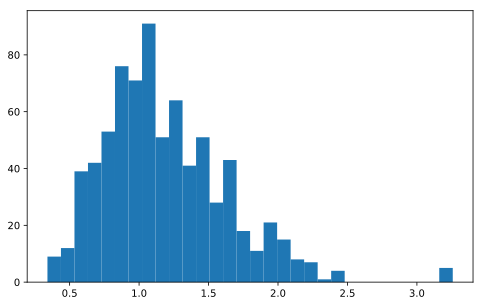

In [35]:
z_train = np.log(5.2/(5.2-y_train))
plt.hist(z_train, bins = 30);

In [36]:
df.shape

(1015, 24)

In [37]:
cols_to_use = ['countreports', 'length', 'gain', 'hpoint'] + list(df.columns[10:])

In [38]:
cols_to_use

['countreports',
 'length',
 'gain',
 'hpoint',
 'Wildflowers/Meadows',
 'Mountain views',
 'Dogs allowed on leash',
 'Established campsites',
 'Waterfalls',
 'Good for kids',
 'Fall foliage',
 'Ridges/passes',
 'Wildlife',
 'Old growth',
 'Summits',
 'Lakes',
 'Rivers',
 'Coast']

In [76]:
mock_df = df.copy()[cols_to_use]

## Log transform the continuous features

In [77]:
mock_df['log_count'] = np.log1p(mock_df.countreports)
mock_df['log_length'] = np.log1p(mock_df.length)
mock_df['log_gain'] = np.log1p(mock_df.gain)
mock_df['log_hpoint'] = np.log1p(mock_df.hpoint)

In [78]:
mock_df = mock_df.drop(['countreports', 'length', 'gain', 'hpoint'], axis=1)

In [ ]:
ssX = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(mock_df, df['rating'])

In [86]:
X_train_scaled = ssX.fit_transform(X_train)
z_train = np.log(5.2/(5.2-y_train))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


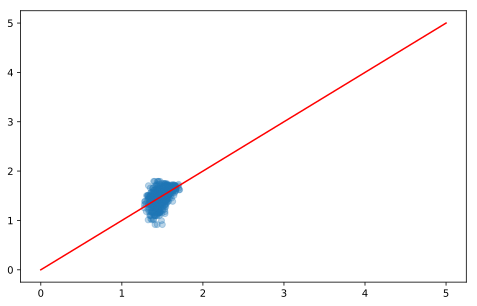

In [87]:
lm = RidgeCV(alphas=[1e-3, 1e-1, 1, 10])
lm.fit(X_train_scaled, np.log1p(y_train))
plt.scatter(lm.predict(X_train_scaled), np.log1p(y_train), alpha=0.3)
plt.plot([0,5], [0,5], 'r-');

In [88]:
y_predict =np.exp(lm.predict(X_train_scaled))

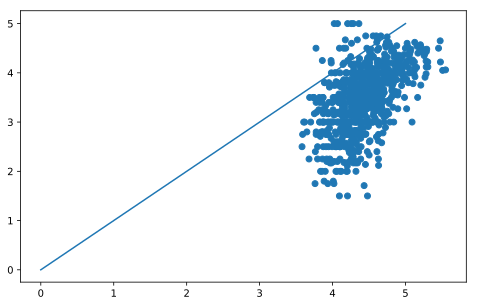

In [89]:
plt.scatter(y_predict, y_train)
plt.plot([0,5],[0,5]);

In [90]:
mock_df.columns[-5:]

Index(['Coast', 'log_count', 'log_length', 'log_gain', 'log_hpoint'], dtype='object')

### Testing out a Random Forest Regressor here with a limited subset of the features

In [99]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

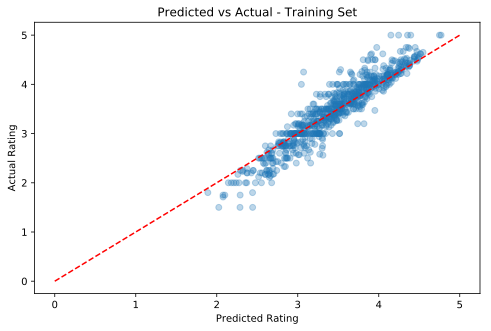

In [94]:
plt.scatter(rf.predict(X_train), y_train, alpha=0.3)
plt.plot(range(6), 'r--')
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Predicted vs Actual - Training Set");

List of features by largest coefficient

In [95]:
X_train.columns[np.argsort(rf.feature_importances_)[::-1]]

Index(['log_count', 'log_hpoint', 'log_length', 'log_gain', 'Old growth',
       'Ridges/passes', 'Mountain views', 'Summits', 'Waterfalls',
       'Dogs allowed on leash', 'Wildlife', 'Wildflowers/Meadows', 'Rivers',
       'Fall foliage', 'Established campsites', 'Lakes', 'Good for kids',
       'Coast'],
      dtype='object')

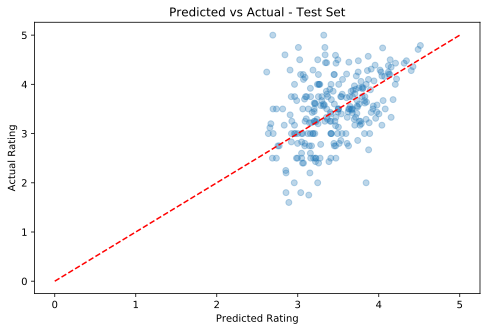

In [96]:
plt.scatter(rf.predict(X_test), y_test, alpha=0.3)
plt.plot(range(6), 'r--')
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Predicted vs Actual - Test Set");